<a href="https://colab.research.google.com/github/uhsipra/AntiVaCCers/blob/main/Twitter_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Twitter Sentiment Analysis Using NB, logistic regression, and SVM using the "Sentiment140Dataset" provided by Kaggle

In [ ]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

We will now read and load the data from the twitter dataset. 

The dataset contains 1.6 million tweets along with the sentiment of those tweets (0 being a negative sentiment and 4 being a positive sentiment).

In [ ]:
# We will import the dataset

dataset_columns = ['target', 'ids', 'data', 'flag', 'user', 'text'] # This is to add lables to the columns 
dataset_encoding = "ISO-8859-1"

df = pd.read_csv('Twitter_dataset.csv', encoding = dataset_encoding, names = dataset_columns)
df.sample(5)

,target,ids,data,flag,user,text
1312912,4,2013717925,Tue Jun 02 23:23:17 PDT 2009,NO_QUERY,rawilson,@SLessard just buying the album now on itunes ...
656867,0,2240717347,Fri Jun 19 10:04:46 PDT 2009,NO_QUERY,LorenMoylan,Not feeling well and in a really bad mood.
109468,0,1824567978,Sun May 17 01:57:14 PDT 2009,NO_QUERY,chante4dannyxxx,im kinda bored theres no one too talk too it ...
159159,0,1956774220,Thu May 28 22:39:24 PDT 2009,NO_QUERY,Kamjam9797,Back working on essays!!!
1260851,4,1998454409,Mon Jun 01 18:34:32 PDT 2009,NO_QUERY,chuenoi,@davepinton U can do it! Not that I'm against ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Data Preprocessing

We need to extract the important words from the tweets and the sentiment associated with them.

In [ ]:
# We need to clean up the data by removing stopwords, emojis and converted to lowercase

# Using only 10% of the dataset as it is to large otherwise for preprocessing time
#df = df.sample(frac=.10)

# We will focus on only the text of the tweets and the sentiment (target)
dataset = df[['text', 'target']]

# We will replace "4" with a "1" for positive sentiment
dataset['target'] = dataset['target'].replace(4,1)

# Turning all tweets into lowercase
dataset['text'] = dataset['text'].str.lower()
dataset['text'].tail()
len(dataset['text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


1600000

Creating stopwords set

In [ ]:
# Creating a stopwords set
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
# Removing the stop words from tweet text

STOPWORDS = set(stopwordlist)

def removing_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset['text'] = dataset['text'].apply(lambda text: removing_stopwords(text))
dataset['text'].tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1599995                 woke up. no school best feeling ever
1599996    thewdb.com - cool hear old walt interviews! â...
1599997                     ready mojo makeover? ask details
1599998    happy 38th birthday boo alll time!!! tupac ama...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, dtype: object

In [ ]:
# Removing puncuation

import string

english_punctuation = string.punctuation
punctuations_list = english_punctuation

def removing_punctuation(text):
  translator = str.maketrans('', '', punctuations_list)
  return text.translate(translator)

dataset['text'] = dataset['text'].apply(lambda text: removing_punctuation(text))
dataset['text'].tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [ ]:
# Tokensizing the text from tweets

dataset['text'] = dataset['text'].apply(lambda x: x.split())
dataset['text'].tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1599995          [woke, up, no, school, best, feeling, ever]
1599996    [thewdbcom, cool, hear, old, walt, interviews,...
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999    [happy, charitytuesday, thenspcc, sparkscharit...
Name: text, dtype: object

In [ ]:
# Stemming the data
import nltk
st = nltk.PorterStemmer()

def stem_data(data):
  text = [st.stem(word) for word in data]
  return data

dataset['text'] = dataset['text'].apply(lambda x: stem_data(x))
dataset['text'].tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


1599995          [woke, up, no, school, best, feeling, ever]
1599996    [thewdbcom, cool, hear, old, walt, interviews,...
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999    [happy, charitytuesday, thenspcc, sparkscharit...
Name: text, dtype: object

In [ ]:
# Lemmatizing the data
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()

def lemm_data(data):
  text = [lm.lemmatize(word) for word in data]
  return data

dataset['text'] = dataset['text'].apply(lambda x: lemm_data(x))
dataset['text'].tail()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


1599995          [woke, up, no, school, best, feeling, ever]
1599996    [thewdbcom, cool, hear, old, walt, interviews,...
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999    [happy, charitytuesday, thenspcc, sparkscharit...
Name: text, dtype: object

In [ ]:
# TEST CODE
test = list(dataset['text'])
len(test)


1600000

In [ ]:
# Concatonating the individual words into a single sentence


for i in range(len(test)):
  test[i] = " ".join(test[i])

dataset['cleantext'] = test
dataset['cleantext'].tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1599995                  woke up no school best feeling ever
1599996    thewdbcom cool hear old walt interviews â« ht...
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: cleantext, dtype: object

In [ ]:
# Saving the pre-processed data in a csv file

dataset.to_pickle('Preprocessed_data.pkl')

Creating figure of words with negative sentiment

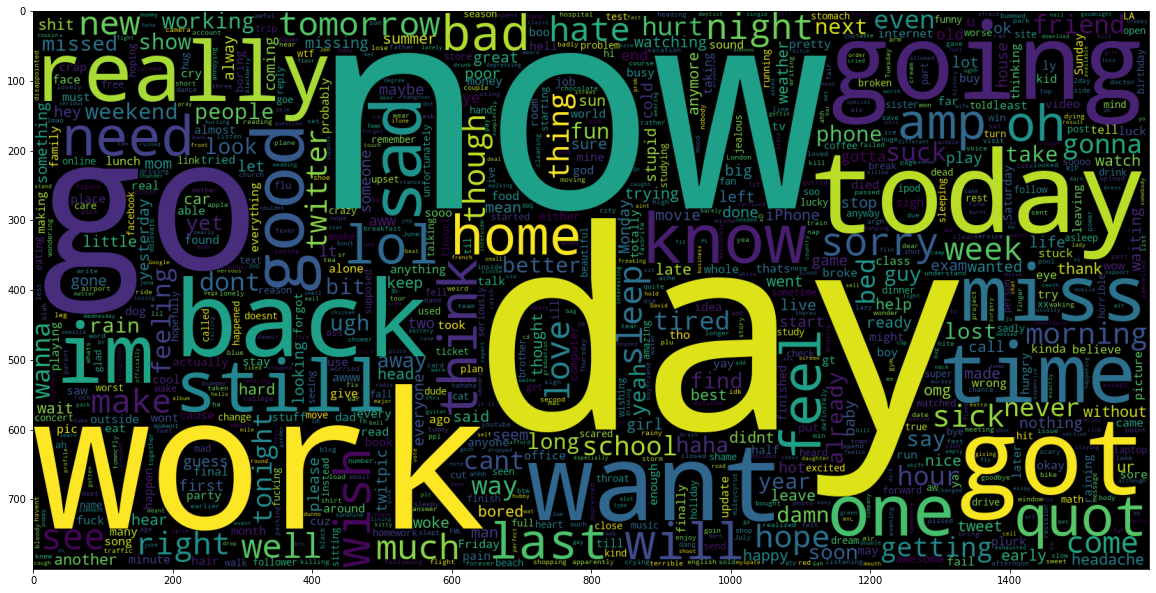

In [ ]:
data = df[['text', 'target']]
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Creating figure of words with postive sentiment

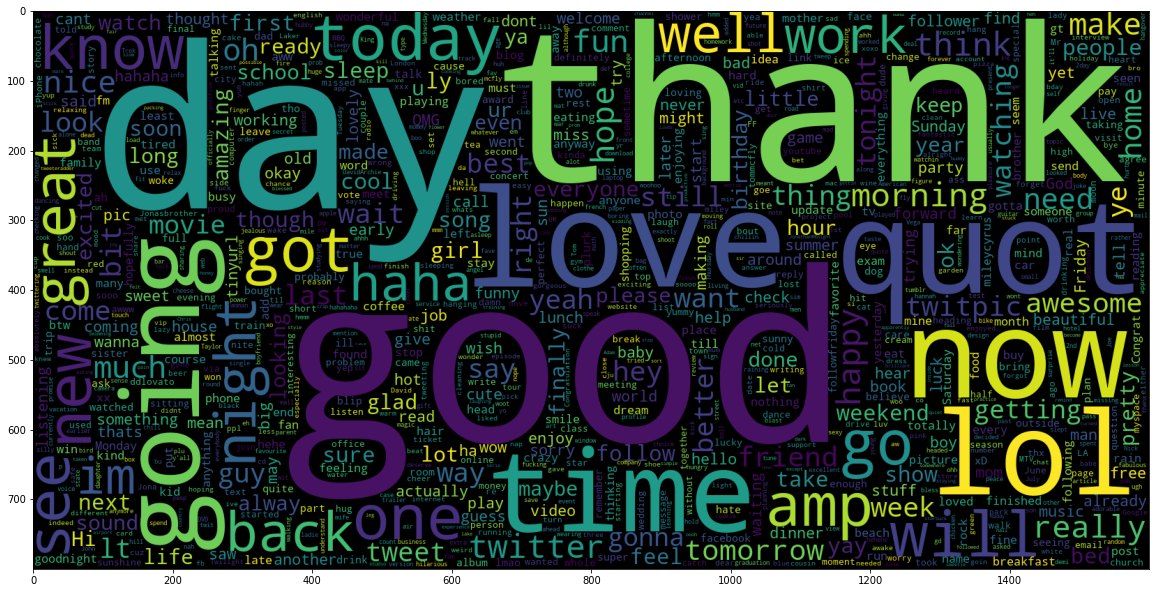

In [ ]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)